In [2]:
import obspy
import os
import matplotlib.pyplot as plt
from numpy import diff
import numpy as np
from os import listdir
from os.path import isfile, join
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *

In [3]:
import seisbench
import seisbench.models as sbm
import seisbench.data as sbd
from sklearn.metrics import confusion_matrix

In [4]:
signalpath = os.getcwd() + r'/data/signal/'
noisepath = os.getcwd() + r'/data/noise/'


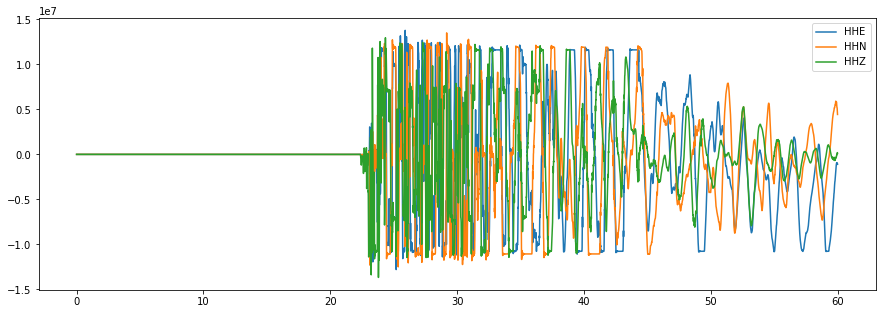

In [5]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

client = Client("INGV")

t = UTCDateTime(2009, 4, 6, 1, 32)
stream = client.get_waveforms(network="MN", station="AQU", location="*", channel="HH?", starttime=t+20, endtime=t+80)
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
for i in range(3):
    ax.plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
ax.legend()

In [6]:
stream

3 Trace(s) in Stream:
MN.AQU..HHE | 2009-04-06T01:32:19.998597Z - 2009-04-06T01:33:19.998597Z | 100.0 Hz, 6001 samples
MN.AQU..HHN | 2009-04-06T01:32:19.998597Z - 2009-04-06T01:33:19.998597Z | 100.0 Hz, 6001 samples
MN.AQU..HHZ | 2009-04-06T01:32:19.998597Z - 2009-04-06T01:33:19.998597Z | 100.0 Hz, 6001 samples

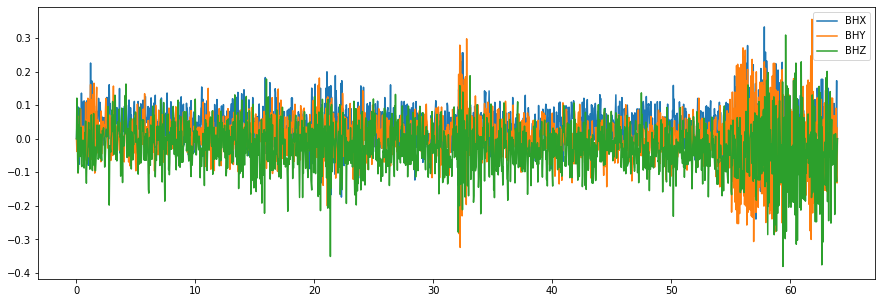

In [7]:
stream = obspy.read('data/signal/1512130231_005_P.mseed')

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
for i in range(3):
    ax.plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
ax.legend()


In [8]:
stream

3 Trace(s) in Stream:
.005..BHX | 2017-12-01T12:10:31.032000Z - 2017-12-01T12:11:35.000000Z | 31.2 Hz, 2000 samples
.005..BHY | 2017-12-01T12:10:31.032000Z - 2017-12-01T12:11:35.000000Z | 31.2 Hz, 2000 samples
.005..BHZ | 2017-12-01T12:10:31.032000Z - 2017-12-01T12:11:35.000000Z | 31.2 Hz, 2000 samples

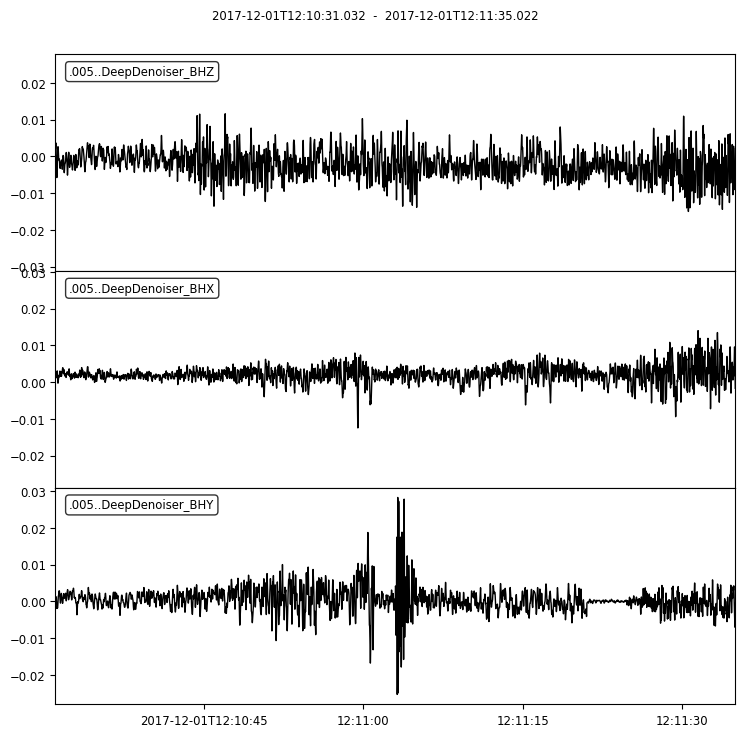

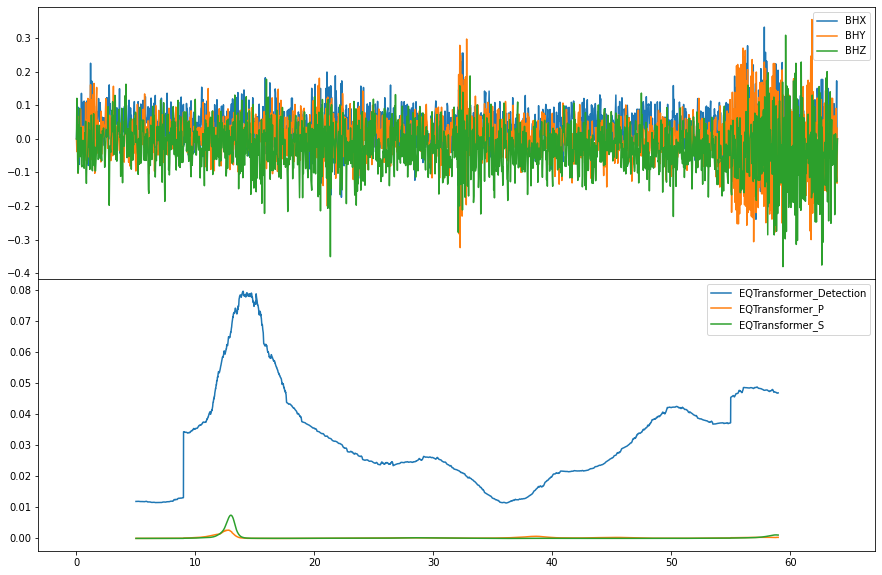

In [9]:
model = sbm.DeepDenoiser.from_pretrained("original")
annotations = model.annotate(stream)
annotations.plot()

picker = sbm.EQTransformer.from_pretrained("stead")

annotations = picker.annotate(annotations,strict=False)
annotations

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})

offset = annotations[0].stats.starttime - stream[0].stats.starttime
for i in range(3):
    axs[0].plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
    if annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
        axs[1].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].stats.channel)

axs[0].legend()
axs[1].legend()

In [10]:
signalfiles = [f for f in listdir(signalpath) if isfile(join(signalpath, f))]
noisefiles = [f for f in listdir(noisepath) if isfile(join(noisepath, f))]

In [11]:
stream = obspy.read('data/signal/1512130231_005_P.mseed')
sampling_rate = stream[0].stats['sampling_rate']
startidx = int(1000 - 3 * sampling_rate)
endidx = int(1000 + 2 * sampling_rate)
signaldata= [obspy.read(signalpath + signalfiles[i]) for i in range(len(signalfiles))] 
signal = np.array([[signaldata[i][0].data, signaldata[i][1].data, signaldata[i][2].data] for i in range(len(signaldata))])
noisedata = [obspy.read(noisepath + noisefiles[i]) for i in range(len(noisefiles))] 
noise = np.array([[noisedata[i][0].data, noisedata[i][1].data, noisedata[i][2].data] for i in range(len(noisedata))])
data = np.concatenate((signal[:,:, startidx:endidx], noise[:,:, startidx:endidx]))
#data = data.reshape(data.shape[0],-1)
target = np.array([1 for i in range(len(signal))]+[0 for i in range(len(noise))])

In [12]:
np.random.seed(0)
train_idx = np.random.choice(np.arange(0, len(data)), int(len(data)*0.9),replace = False)
train_data = data[train_idx]
train_y = target[train_idx]
test_data = data[~np.isin(np.arange(len(data)), train_idx)]
test_y = target[~np.isin(np.arange(len(target)), train_idx)]

In [13]:
my_init = keras.initializers.glorot_uniform(seed=1)

model = keras.Sequential([
    # Input layer, do not change
    InputLayer(input_shape=(train_data.shape[1],train_data.shape[2])),
    # Inner layers, can add/change
    Dense(64,  activation='relu',kernel_initializer=my_init),
    Dropout(0.2),
    Dense(32,  activation='relu',kernel_initializer=my_init),
    Dense(16,  activation='relu',kernel_initializer=my_init),
    Dense(8,  activation='relu',kernel_initializer=my_init),
    # Output layer, do not change
    Flatten(),
    Dense(1, activation='sigmoid')])

model.compile(
    # Optimization algorithm, specify learning rate
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    # Loss function for a binary classifier
    loss='binary_crossentropy',
    # Diagnostic quantities
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3, 64)             10048     
_________________________________________________________________
dropout (Dropout)            (None, 3, 64)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3, 32)             2080      
_________________________________________________________________
dense_2 (Dense)              (None, 3, 16)             528       
_________________________________________________________________
dense_3 (Dense)              (None, 3, 8)              136       
_________________________________________________________________
flatten (Flatten)            (None, 24)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2

In [14]:
model.fit(train_data, train_y, epochs = 50, batch_size = 32)

Train on 17165 samples
Epoch 1/50
17165/17165 [==============================] - 4s 245us/sample - loss: 0.0782 - accuracy: 0.9784
Epoch 2/50
17165/17165 [==============================] - 3s 147us/sample - loss: 0.0187 - accuracy: 0.9943
Epoch 3/50
17165/17165 [==============================] - 3s 148us/sample - loss: 0.0090 - accuracy: 0.9973
Epoch 4/50
17165/17165 [==============================] - 3s 149us/sample - loss: 0.0080 - accuracy: 0.9974
Epoch 5/50
17165/17165 [==============================] - 3s 148us/sample - loss: 0.0057 - accuracy: 0.9983
Epoch 6/50
17165/17165 [==============================] - 3s 146us/sample - loss: 0.0071 - accuracy: 0.9981
Epoch 7/50
17165/17165 [==============================] - 3s 147us/sample - loss: 0.0068 - accuracy: 0.9977
Epoch 8/50
17165/17165 [==============================] - 3s 146us/sample - loss: 0.0065 - accuracy: 0.9981
Epoch 9/50
17165/17165 [==============================] - 3s 147us/sample - loss: 0.0200 - accuracy: 0.9951
Epoch

In [18]:
pred = model.predict(test_data) >= 0.5
confusion_matrix(test_y,pred)

array([[1774,    0],
       [   7,  127]])

In [19]:
mismatched_idx = np.where(~np.isin(np.arange(len(data)), train_idx) == True)[0][np.where(pred.reshape(1,-1)*1 != test_y)[1]]
mismatched_idx

array([ 80, 107, 128, 755, 824, 833, 966])

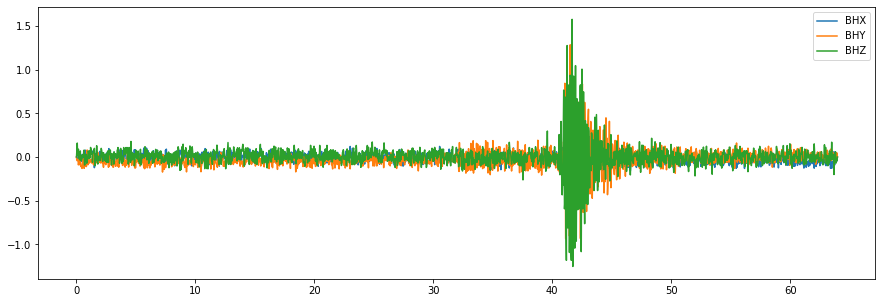

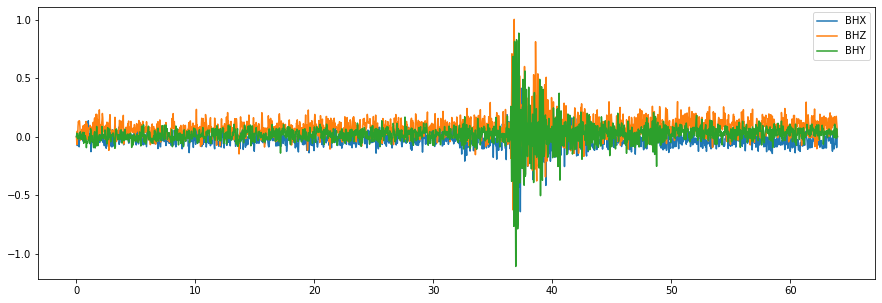

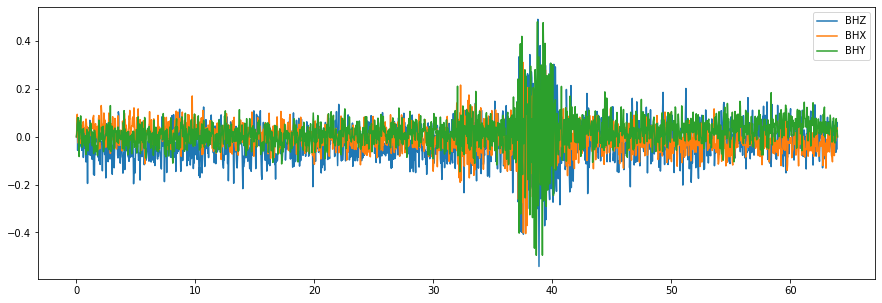

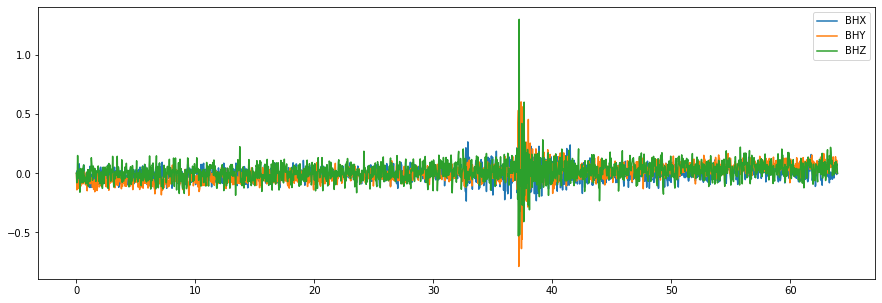

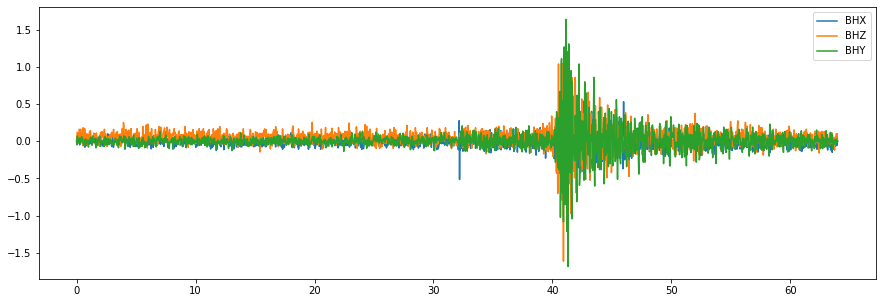

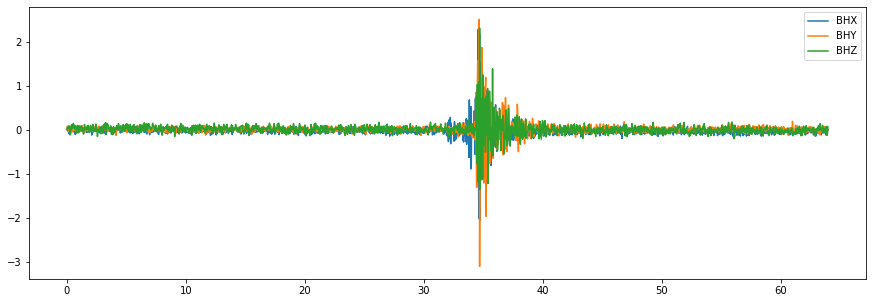

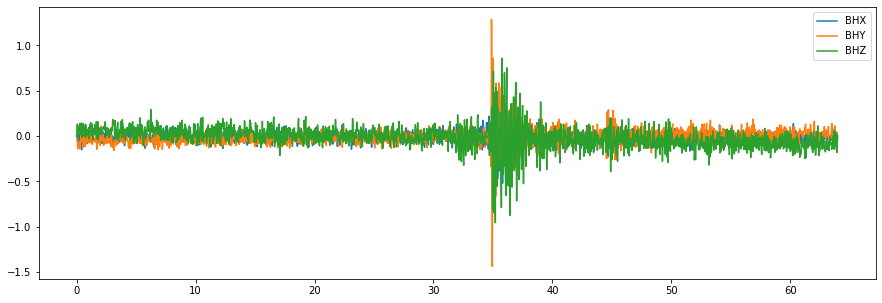

In [20]:
for i in mismatched_idx:
    stream = obspy.read('data/signal/'+signalfiles[i])

    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(111)
    for i in range(3):
        ax.plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
    ax.legend()
